In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC Dataset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [2]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


sys.path.insert(0, "../")
import utils.settings as s

s.init()
seed = s.seed
pd.set_option('display.max_columns', None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

target = "Target_businessreduction"

## save models and their evaluation in following folders:
Path(f"../../model_results/bayesian_network/businessreduction").mkdir(parents=True, exist_ok=True)


In [65]:
infile_name = "final_predictors_Target_businessreduction_10_1"
data = pd.read_excel(f"../model_results/selected_features/degree_of_loss/{infile_name}.xlsx")
print(data.shape)
# print(data.tail(2))

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f'bn_{target}'

# Select the columns to use in the NPBN
columns_used=range(0, 5) # 11 use currnetly 10 most important features + target for BN
data = data.iloc[:,columns_used] 

# Extract the variable names
names_list = tuple(data.columns)
names = {k: i for i, k in enumerate(names_list)}
print("Using following features:", names)

# mylist.remove(targetvalue)
# mylist.insert(0, targetvalue)
# shp_sector, emploees, reg_capital, avgmon_sale, mon_income
# flovelo, w_depth, contamam 0, inund_h
# flood_exp, emergy_2, water_bar_impl, pump_eq_impl, protect_valuabl_impl, resistant_m_b_impl, elec_higher_impl
# overall_building_problm, b_area, 

(353, 17)
Using following features: {'Target_businessreduction': 0, 'flowvelocity': 1, 'emergency_measures': 2, 'water_depth_cm': 3, 'bage': 4}


In [88]:
# Extract number of nodes from data
# N = 2 #11  # 3
N = data.shape[1]  # number of nodes == number of features + target

# Defining the structure of the BN
parent_cell = [None]*N

### --- Schema example --- ###
# parent_cell[0] = []           # climate (no parents)
# parent_cell[1] = [2]          # arts (parent node: recreation)
# parent_cell[4] = [1, 2, 3, 0] # target=safety (parents: all other variables)

### --- Schema kid_cell = parent_cells --- ###
parent_cell[0] = [1, 2, 3, 4]#,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
parent_cell[1] = [3] #[names["water_depth_cm"], names["inundation_duration_h"]]           # fv (parent wd)
parent_cell[2] = [1]                                                                     # emergency (parend fv) and bage
parent_cell[3] = []                                                                        # wd
## wd -> fv --> emer --> bred
parent_cell[4] = [3]          # TODO or parent is fv or wd                                         # bage

# # not hydro <- building properties
#parent_cell[3] = [] #names["shp_registered_capital_euro"]]                                     #   shp_employees (parent node: shp_registered_capital_euro)   
# parent_cell[4] = [names["shp_registered_capital_euro"]]                                 #   shp_avgmonthly_sale_cat (parent node: shp_registered_capital_euro)
# parent_cell[5] = [names["shp_registered_capital_euro"], names["water_depth_cm"]]        #   water_barriers_impl   (parent: shp_registered_capital_euro) or dependence on water_depth ?
# parent_cell[6] = [names["shp_registered_capital_euro"]]                                 #   b_area (parent nodes: shp_registered_capital_euro)
# parent_cell[6] = [names["shp_registered_capital_euro"]]                                 #   B_age (parent nodes: shp_registered_capital_euro)
# parent_cell[7] = [names["shp_avgmonthly_sale"]] # , names["water_depth_cm"]]        #   pumping_equipment_impl  (parent:  shp_registered_capital_euro) or dependence on water_depth ?
# parent_cell[8] = []                                                                     #   water_depth_cm 
# parent_cell[9] =  [names["shp_avgmonthly_sale"]]                                    #   hh_monthly_income_cat (parent node: shp_avgmonthly_sale_cat)   
# parent_cell[10] = []                                                                    #   inundation_duration_h


## chec spearman correlations of feautres: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target



parent_cell

[[1, 2, 3, 4], [3], [1], [], [3]]

In [89]:
# def bn_rankcorr(parent_cell, data, var_names, is_data=True, plot=False, fig_name=''):
#     """
#     bn_rankcorr creates a rank correlation matrix R 
#     from a defined Bayesian Network (BN) structure parent_cell
#     and a data matrix data.
    
#     Parameters
#     ----------
#     parent_cell : list
#         A list of lists containing the structure of the BN.
#         Each list is a node of the BN and contains a list  
#         of the node's parents, defined as a list with 
#         reference to particular list(s).
        
#         This an example BN with 4 nodes and 6 arcs:
#         parent_cell[0] = []         # Node 1 with no parents
#         parent_cell[1] = [0, 2]     # Node 2 with two parents 
#                                     # (nodes 1 and 3)
#         parent_cell[2] = [0]        # Node 3 with one parent
#                                     # (node 1)
#         parent_cell[3] = [0, 1, 2]  # Node 4 with three parents
#                                       (nodes 1, 2 and 3)
#         Note: the BN needs to be an acyclic graph!
#     data : pandas.core.frame.DataFrame
#         By default, a matrix containing data for 
#         quantifying the NPBN. Data for each node need to be 
#         located in columns in the same order as specified 
#         in parent_cell. The number of columns needs to equal 
#         the number of nodes specified in 
#         parent_cell.
#         Optionally, a cell array of rank correlations can
#         be used, one conditional correlation per arc, 
#         following the same structure as parent_cell.
#     is_data : int
#         Specifies the input data type:
#             0 - cell array DATA contains rank correlations;
#             1 - matrix DATA contains actual data.
#     plot : bool
#         A plot of correlation matrix R can be displayed.
#             The options are:
#             False - do not create a plot (default);
#             True - create a plot.
#     var_names : list
#         a list containing names of the nodes for the plot
    
#     Returns
#     -------
#     R : numpy.ndarray
#         Rank Correlation Matrix
        
#     """
#     # Checking validity of the input dimensions
#     if is_data:
#         if data.shape[1] != len(parent_cell):
#             raise argparse.ArgumentTypeError('Number of data columns does not match the number of parent cells')
#             # Reading the number of variables
#         N = data.shape[1]

#     if not is_data:
#         if len(data) != len(parent_cell):
#             raise argparse.ArgumentTypeError('Number of data columns does not match the number of parent cells')
#             # Reading the number of variables
#         N = len(data)

#     # Constructing a valid 'sampling order', which means that the node with no 
#     # parents will be the first in the sampling order (SO) and so forth.
#     SO = []
#     while len(SO) < N:
#         # Storing the elements in [0:N] not contained in [sampling_order]
#         # (using auxiliary function 9)
#         indices = list_dif(range(N), SO)
#         for i in indices:
#             # qq is empty if the parents of i are already contained in SO
#             qq = list_dif(parent_cell[i], SO)
#             if not qq:
#                 # in case qq is empty, adding i to the sampling order
#                 SO.append(i)

#     # Creating a data matrix out of specified rank correlation matrix, if such
#     # input was chosen. 
#     if not is_data:
#         import copy
#         data_r_to_p = copy.deepcopy(data)
#         for i in range(len(data)):
#             for j in range(len(data[i])):
#                 # Transforming Spearman's into Pearson's correlation 
#                 # (auxiliary function 1)
#                 data_r_to_p[i][j] = ranktopearson(data_r_to_p[i][j])

#     # Transforming the data to standard normal (auxiliary function 7)
#     if is_data:
#         norm_data, _ = NormalTransform(data)

#     # Initializing the correlation matrix R
#     R = np.zeros((N, N))
#     np.fill_diagonal(R, 1)

#     # Initializing a cell containing information during the recursive
#     # calculation of the correlation matrix given the network 
#     # (see PartCorr function (3))
#     L = [[None] * (N) for i in range(N)]

#     # Starting the loop for recursively calculating the correlation matrix by
#     # the second node
#     for i in range(1, N):
#         # Variables for the looping
#         cond = []  # Vector storing the conditionalized variables
#         T = np.zeros(i)  # Vector of the same length of previous nodes
#         counter = 0  # Counter for recursive estimation

#         seq = parent_cell[SO[i]]  # Contains the parent of the i-th node
#         seq2 = list_dif(SO[0:i], seq)  # Contains the previous (same order of
#         # SO!) nodes that are not parents

#         # Looping over the parents of the i-th node
#         for j in seq:
#             if not is_data:
#                 T[counter] = data_r_to_p[SO[i]][len(cond)]
#             else:
#                 # Calculating the partial correlation between the node 
#                 # (normdata(:,SO(i))) at its parent (normdata(:,j)) given the
#                 # conditioning variable(s) (normdata(:,cond))
#                 T[counter] = pg.partial_corr(data=norm_data,
#                                              x=norm_data.columns[SO[i]],
#                                              y=norm_data.columns[j],
#                                              covar=list(norm_data.columns[i]
#                                                         for i in cond),
#                                              method='pearson').r.values[0]
#             s = T[counter]

#             # Looping over all the remaining parents
#             for k in range(len(cond) - 1, -1, -1):
#                 # Recursivelly calculating the correlation between nodes 
#                 # accounting for the conditional/partial correlation 
#                 # established by the BN (auxiliary function 3)
#                 [L, r1] = PartCorr(j, cond[k], cond[0:k], R, L, N + 1)
#                 # Based on the conditional/partial correlation, calculating the
#                 # resulting correlation coefficient (all the properties of the 
#                 # correlation matrix are guaranteed)
#                 shat = s * np.sqrt((1 - T[k] ** 2) * (1 - (r1) ** 2)) + T[k] * r1
#                 s = shat
#             if np.isnan(s):
#                 R[SO[i], j] = s
#                 R[j, SO[i]] = s
#                 print('Error, s = nan')
#                 print('j= ' + str(j) + ', k= ' + str(k))
#             else:
#                 # Saving the correlation coefficients calculated in the upper 
#                 # and lower triangle of the matrix R.
#                 R[SO[i], j] = s
#                 R[j, SO[i]] = s
#             counter += 1
#             if not cond:
#                 cond = [j]
#             else:
#                 cond.append(j)

#         # Looping over the previous nodes (based on the ordering in SO) which 
#         # are not parents, stored in seq2.
#         for j in seq2:
#             T[counter] = 0
#             s = T[counter]
#             for k in range(len(cond) - 1, -1, -1):
#                 if T[k] != 0 or s != 0:
#                     # Recursively calculating the correlation between nodes 
#                     # accounting for the conditional/partial correlation 
#                     # established by the BN (auxiliary function 3)
#                     L, r1 = PartCorr(j, cond[k], cond[0:k], R, L, N + 1)
#                     # Based on the conditional/partial correlation, calculating 
#                     # the resulting correlation coefficient (all the properties 
#                     # of the correlation matrix are guaranteed)
#                     shat = s * np.sqrt((1 - T[k] ** 2) * (1 - (r1) ** 2)) + T[k] * r1
#                     s = shat

#             # Storing the results
#             R[SO[i], j] = s
#             R[j, SO[i]] = s
#             counter += 1
#             if not cond:
#                 cond = [j]
#             else:
#                 cond.append(j)
#     # Transforming Pearson's correlation into Spearman's rank correlation 
#     # (auxiliary function 2)
#     R = pearsontorank(R)
#     if plot:
#         rank_corr_mat_fig(var_names, R)

#     return R

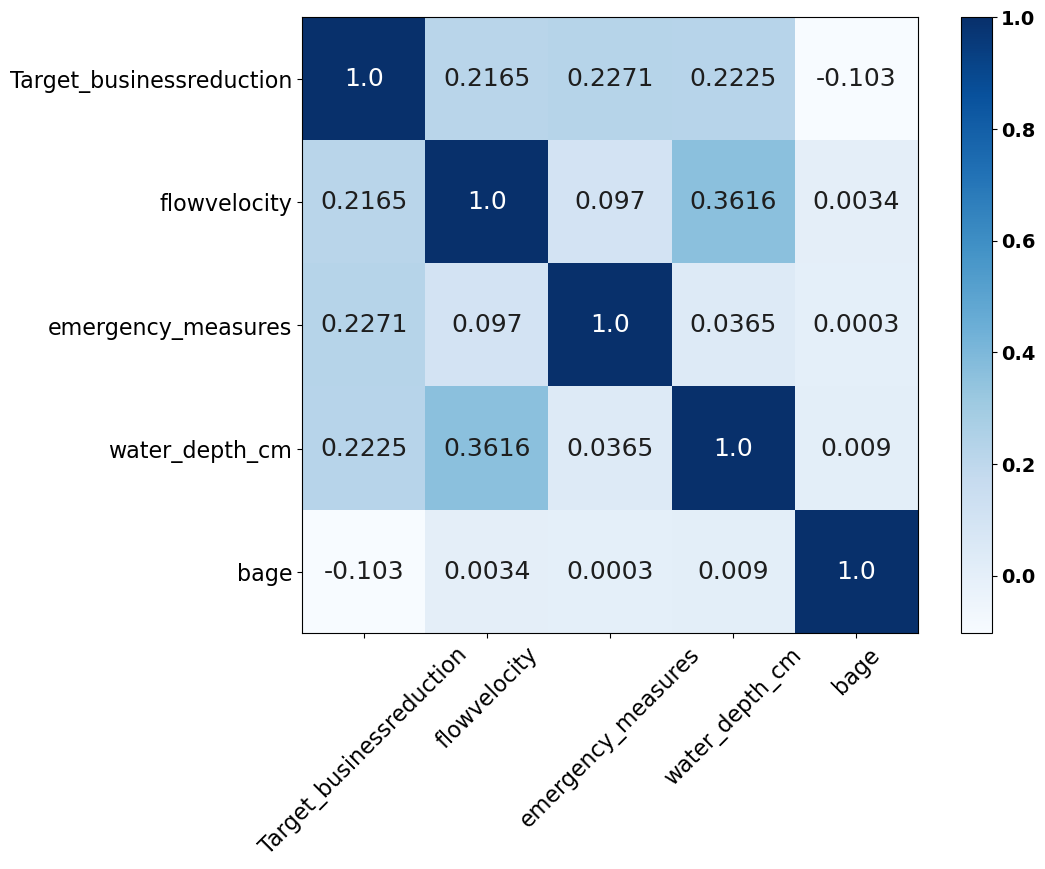

In [90]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

# TODO add coef values in cells
# TODO fix x -label shift
R = bn_rankcorr(parent_cell,        # structure of the BN
                data,               # matrix of data
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.


In [92]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[1, 2, 3, 4 ]#, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = data.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              data,             # DataFrame with data
              Output='mean')    # type of output data


## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=data.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_original))
MBE = np.mean(y_pred-y_original)
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making i

In [78]:
## bred
## 2 features (fv -> eme): **
# MAE, MBE, RMSE, R2: 19.592781869688388 4.479676487252124 23.949567693146612 0.07661439251107667
## 2 features (fv , eme): 
# MAE, MBE, RMSE, R2: 19.694834277620398 4.83511926345609 24.055624451123958 0.07716935525404545

## 3 features (fv -> eme, wd): 
# MAE, MBE, RMSE, R2: 19.812639376770537 4.699533994334278 24.505799118556922 0.05333127112893681
## 3 features (wd -> fv -> eme):  **
# MAE, MBE, RMSE, R2: 19.35493597733711 4.44363059490085 24.164246571908436 0.07249607165736519

## 3 features (wd -> fv -> eme, bage):
# MAE, MBE, RMSE, R2: 22.545141643059488 9.892149008498581 30.514144251117656 0.04687016586786781
## 3 features (wd -> fv -> eme, bage -> eme):
# MAE, MBE, RMSE, R2: 22.576861756373937 9.77046628895184 30.532410459867094 0.04444159602270782
## 3 features (wd -> fv -> eme, fv -> bage ):
# MAE, MBE, RMSE, R2: 22.648895750708213 10.135986402266287 30.556529378822894 0.04835896600124946
## 3 features (wd -> fv -> eme, wd -> bage ):
# MAE, MBE, RMSE, R2: 22.519442209631727 9.939201416430594 30.444410570007026 0.048327625353783245


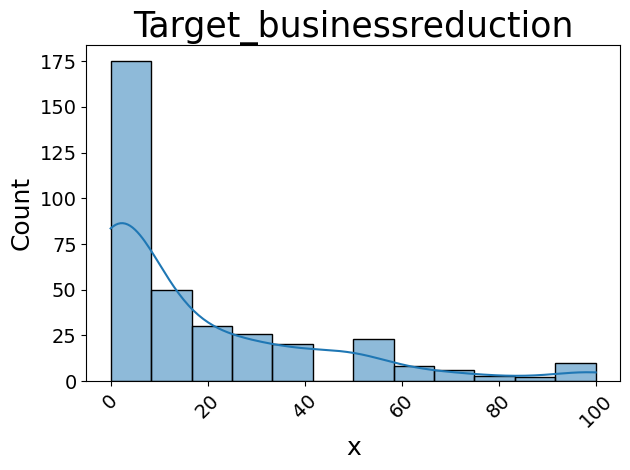

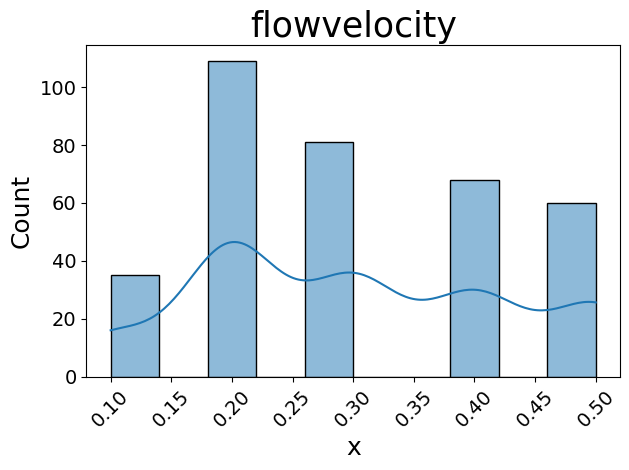

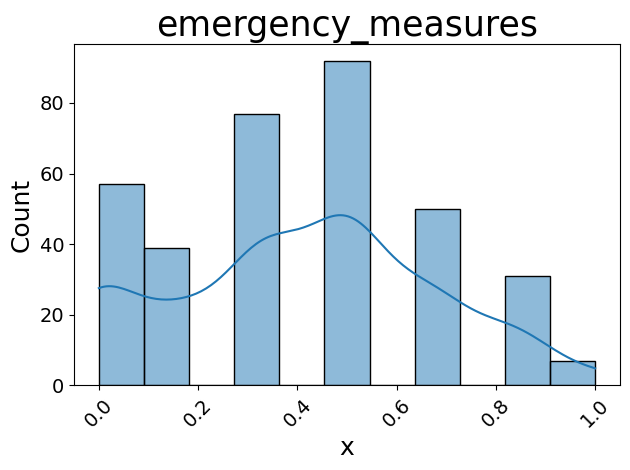

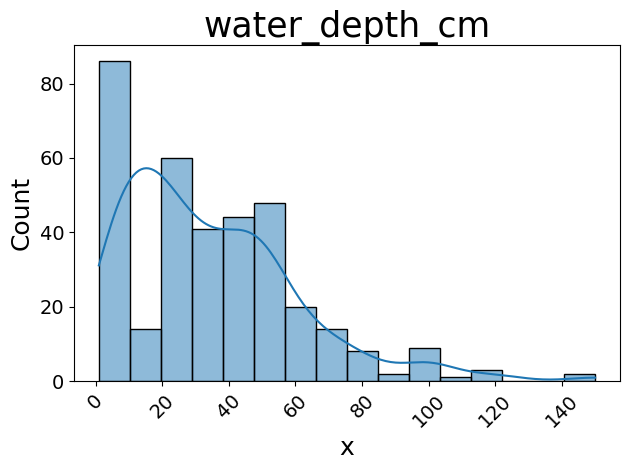

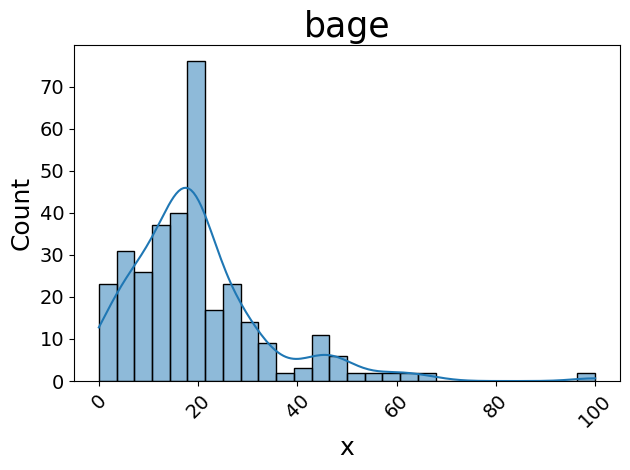

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_Target_businessreduction_margins.pdf'

In [79]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             data.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             data.columns,                      # names of variables
             data = data,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


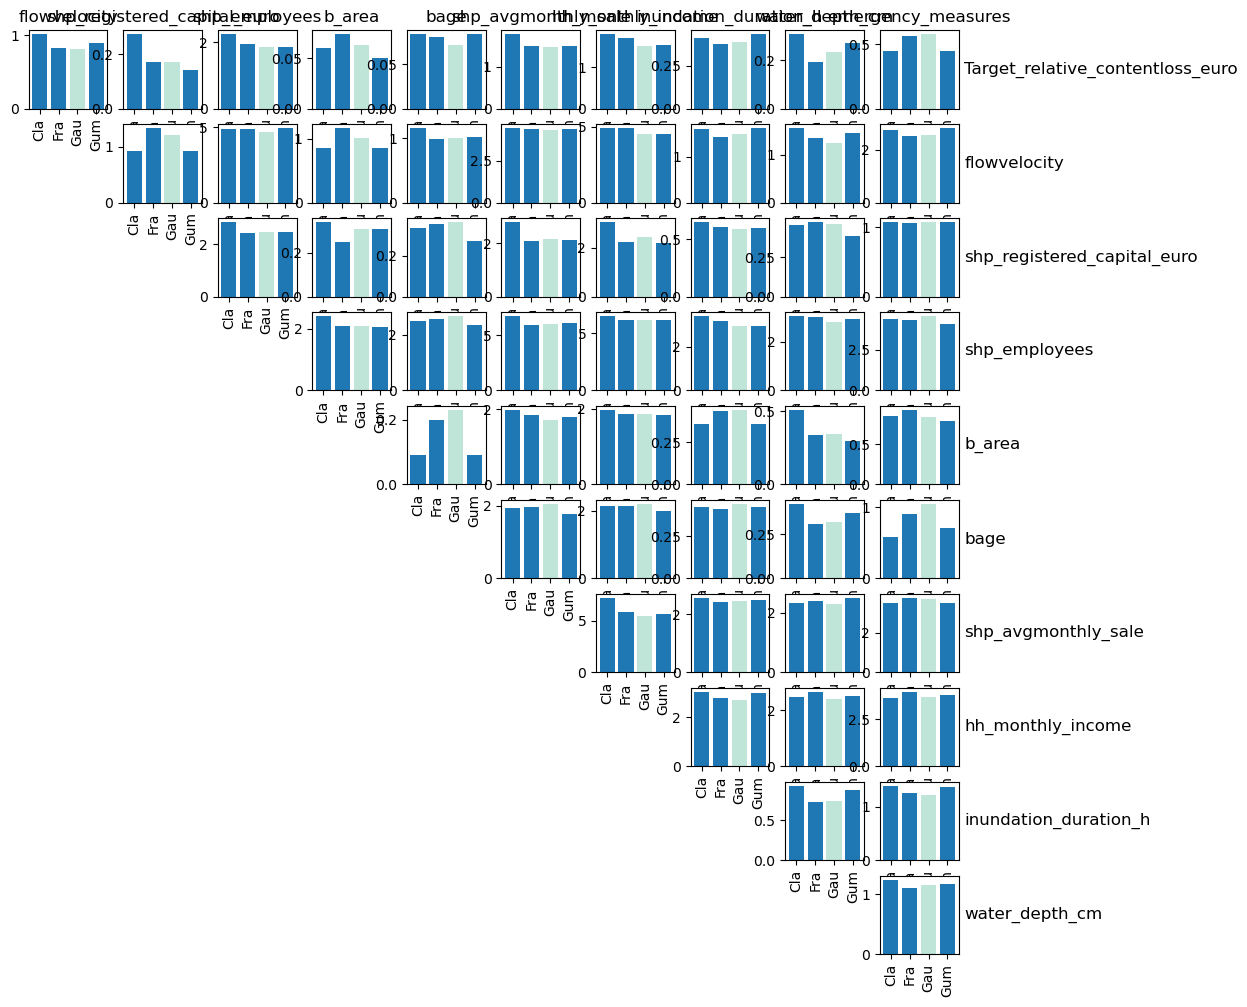

In [11]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(data,                   # DataFrame with data
                  names = data.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

In [12]:
M

,Var1,Var2,r,Clayton,Frank,Gaussian,Gumbel
0,Target_relative_contentloss_euro,flowvelocity,0.263828,1.014663,0.829228,0.816773,0.895479
1,Target_relative_contentloss_euro,shp_registered_capital_euro,0.273843,0.274814,0.169969,0.170619,0.142091
2,Target_relative_contentloss_euro,shp_employees,0.105858,2.250071,1.940503,1.860467,1.845609
3,Target_relative_contentloss_euro,b_area,-0.045066,0.060234,0.074083,0.06343,0.049957
4,Target_relative_contentloss_euro,bage,-0.266082,0.084048,0.080713,0.071532,0.084046
5,Target_relative_contentloss_euro,shp_avgmonthly_sale,0.283974,1.788844,1.506169,1.479901,1.494931
6,Target_relative_contentloss_euro,hh_monthly_income,0.119853,1.798456,1.69679,1.497202,1.540063
7,Target_relative_contentloss_euro,inundation_duration_h,0.19021,0.41297,0.376379,0.389603,0.434001
8,Target_relative_contentloss_euro,water_depth_cm,0.413043,0.307181,0.190514,0.233761,0.269286
9,Target_relative_contentloss_euro,emergency_measures,0.125531,0.447025,0.566304,0.579871,0.447029


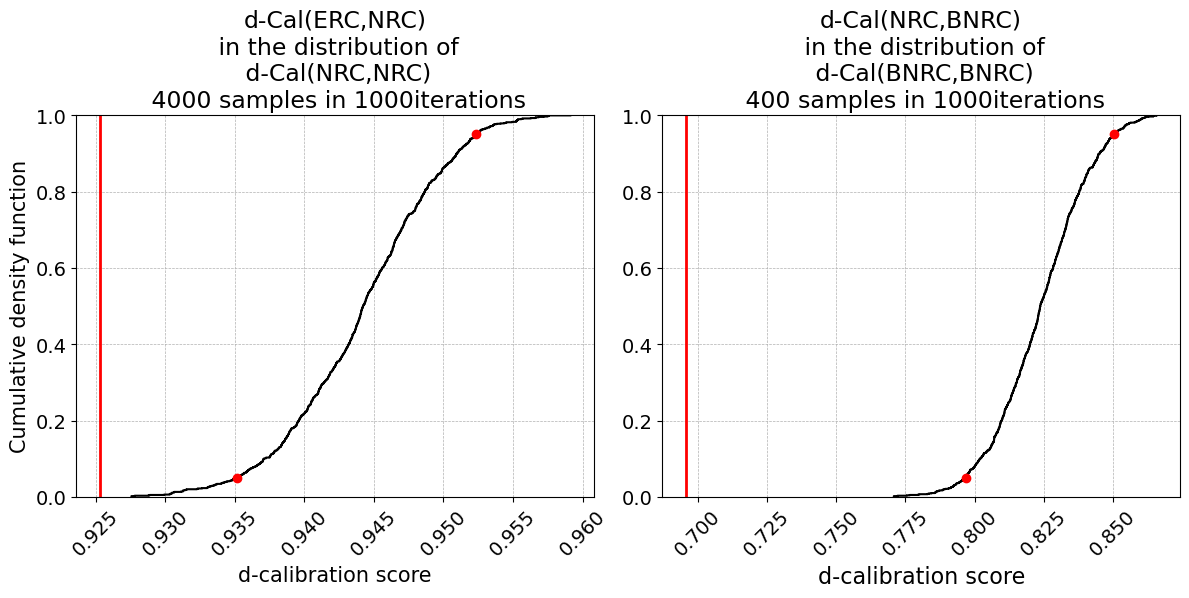

FAILURE: The d-Cal of the empirical rank correlation matrix (ERC) is out of the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [14]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() --> fixed with np.mulitply() in d_cal.py from py_banshee package ~ 1h
## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )

# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            data,     # DataFrame with data
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don't create plot)
                            Type='H',           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large datasets.


In [19]:
data.head(2)#.shape

,Target_relative_contentloss_euro,shp_registered_capital_euro,flowvelocity,shp_employees,shp_avgmonthly_sale_cat,water_barriers_impl,b_area,pumping_equipment_impl,water_depth_cm,hh_monthly_income_cat,inundation_duration_h
7,0.002289,3682.6,2,2,4,5,54.0,5,20,7.0,12.0
9,0.001999,441.9,4,2,1,1,45.0,5,3,3.0,2.0


In [20]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = data.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              data,             # DataFrame with data
              Output='mean')    # type of output data



Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  9%
Making inference. Progress:  9%
Making inference. Progress:  10%
Making inference. Progress:  11%
Making inference. Progress:  12%
Making inference. Progress:  12%
Making inference. Progress:  13%
Making inference. Progress:  14%
Making inference. Progress:  15%
Making inference. Progress:  15%
Making inference. Progress:  16%
Making inference. Progress:  17%
Making inference. Progress:  18%
Making inference. Progress:  18%
Making inference. Progress:  19%
Making inference. Progress:  20%
Making inference. Progress:  21%
Making inference. Progress:  21%
Making inference. Progre

## Evaluation

In [25]:
## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=data.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_original))
MBE = np.mean(y_pred-y_original)
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)

print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict


# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)

# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     F, 
#     data.iloc[:,condition], y_original, 
#     # return_train_score=  # if True: more computanitonal expensive, gives scores of training sets
#     scoring="neg_MAE",# "neg_mean_absolute_error",,  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
#     n_jobs=-1
# ) 


In [27]:

# first try: MAE, MBE, RMSE, R2: 0.22737828120590867 0.18693083465146496 0.4326010916688961 1.055515193816181e-05
# -> moderate overestimation of BN model, stronger overall 


# The coefficient of determination between modelled and observed target 
# is xxx, but the average error (mae: 0.227) is much higher than
# the average value of the response (mean: 0.056), and there is some overestimation bias.
# However, for proper validation, if sufficient data is available, a split-
# -sample validation or a k-fold cross-validation should be performed.

## see how small BN performs than expanded by further variables and check performance


####################################################
############ python meeting #############
## PDP
## google colab #  r - py combine :  
## y_pred , permutation -which fetures/or one feature
## pytorch, keras <-->  R, 
## explore() compare two maps- zomm in --> linked maps

MAE, MBE, RMSE, R2: 0.22737828120590867 0.18693083465146496 0.4326010916688961 1.055515193816181e-05


In [41]:
#?RepeatedKFold

InvalidParameterError: The 'estimator' parameter of cross_validate must be an object implementing 'fit'. Got array([[ 0.16347476],
       [ 0.01371408],
       [ 0.01816009],
       [ 0.16722744],
       [ 1.1       ],
       [ 0.10879648],
       [ 0.05607578],
       [ 0.05824835],
       [ 0.05476475],
       [ 0.02918989],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 0.39124636],
       [ 0.11123776],
       [ 1.1       ],
       [-0.00326076],
       [ 0.07375042],
       [ 0.00628686],
       [ 0.03791784],
       [ 0.09739452],
       [ 0.02054741],
       [ 0.09661246],
       [ 0.14391711],
       [ 0.14089535],
       [ 1.1       ],
       [ 0.10328404],
       [ 0.39148823],
       [ 1.1       ],
       [ 0.07732154],
       [ 0.07326568],
       [ 0.36064486],
       [ 0.04081759],
       [ 0.02596857],
       [ 0.02815278],
       [ 0.05071997],
       [ 1.1       ],
       [ 0.04151131],
       [ 0.18314016],
       [ 0.0260848 ],
       [ 0.04534307],
       [ 0.02867887],
       [ 0.14498903],
       [ 0.05158406],
       [ 0.0069605 ],
       [ 0.09133098],
       [ 0.35257486],
       [ 0.21644883],
       [ 0.48579645],
       [ 0.11176638],
       [ 0.0123673 ],
       [ 1.1       ],
       [ 0.10776571],
       [ 0.06499087],
       [ 0.02842233],
       [ 0.01551382],
       [ 0.04945894],
       [ 0.13813305],
       [ 0.02489687],
       [ 0.07140658],
       [ 0.1064993 ],
       [ 0.093665  ],
       [ 0.01560742],
       [ 0.01974605],
       [ 0.00119183],
       [ 0.33555809],
       [ 0.13194573],
       [ 0.14211835],
       [ 1.1       ],
       [ 0.03241035],
       [ 0.03332841],
       [ 0.02512826],
       [ 0.04624671],
       [ 0.15451778],
       [ 0.02223136],
       [ 1.1       ],
       [ 0.04054287],
       [ 0.04385087],
       [ 0.16462748],
       [ 0.05035138],
       [ 0.03579053],
       [ 0.04792825],
       [ 0.05488011],
       [ 0.0561095 ],
       [ 0.0721532 ],
       [ 0.09131888],
       [ 0.33916393],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 0.18749771],
       [ 0.00866714],
       [ 0.49233727],
       [ 1.1       ],
       [ 0.00453687],
       [ 0.06770779],
       [ 0.08878729],
       [ 0.05905354],
       [ 0.14513796],
       [ 0.0630918 ],
       [ 0.23027807],
       [ 0.07353641],
       [ 0.1260419 ],
       [ 0.0365882 ],
       [ 0.09649585],
       [ 0.37966558],
       [ 1.1       ],
       [ 0.1216051 ],
       [ 0.09615853],
       [ 1.1       ],
       [ 0.12882772],
       [ 1.1       ],
       [ 0.10484207],
       [ 0.05350656],
       [ 0.07701947],
       [ 0.08809262],
       [ 0.18519853],
       [ 0.08644923],
       [ 0.06549602],
       [ 0.02680212],
       [ 0.09621977],
       [ 0.02235033],
       [ 0.11973015],
       [ 0.0831287 ],
       [ 0.03544015],
       [ 0.01996047],
       [ 0.01501593],
       [ 0.15230103],
       [ 0.22635867],
       [ 0.04911022],
       [ 0.03046738],
       [ 0.08326517]]) instead.

In [37]:
data[target].describe()


count    133.000000
mean       0.056082
std        0.144453
min        0.000254
25%        0.003557
50%        0.010001
75%        0.029121
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

In [ ]:
data[target].describe()


count    133.000000
mean       0.056082
std        0.144453
min        0.000254
25%        0.003557
50%        0.010001
75%        0.029121
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

In [28]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)
      
# ## outer cv for evaluation metrics (averaged across outer folds)
# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     model, 
#     X, y, 
#     scoring=["accuracy", "precision", "recall", "f1"],  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
# ) 
# print("outer CV: ACC: %.3f (%.3f)"%(scores["test_accuracy"].mean(), np.std(scores["test_accuracy"])))
# print("outer CV: precision: %.3f (%.3f)"%(scores["test_precision"].mean(), np.std(scores["test_precision"])))
# print("outer CV: recall: %.3f (%.3f)"%(scores["test_recall"].mean(), np.std(scores["test_recall"])))